# Finding spurious structure in high dimensions

It is often impressive how dimension reduction algorithms can find hidden structure lurking in piles of data. But when those data are high-dimensional, we have to be careful.

This code generates a movie of a specific low-dimensional structure (a university logo) being "discovered" amid a high-dimensional dataset that is really just pure noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from __future__ import division, print_function

np.random.seed(12345)

%matplotlib inline

## Load image

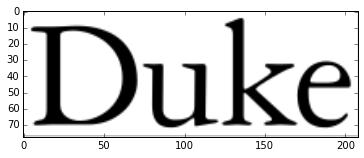

In [2]:
img = mpimg.imread('logo.png')
plt.imshow(img);

##Clean up (i.e., binarize) image

In [3]:
if len(img.shape) > 2:
    img = np.median(img, axis=2)
img = img.astype('int')

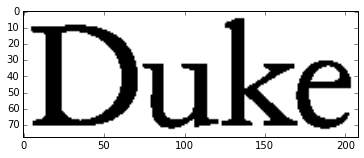

In [4]:
plt.imshow(img, cmap='gray');

## Get random points in image

Get all nonzero pixels

In [5]:
img.shape

(78, 208)

In [6]:
coords = np.nonzero(1 - img)
pairs = zip(*coords)

In [7]:
N = 1000
subset = np.random.choice(xrange(len(pairs)), size=N, replace=False)

In [8]:
pts = np.array(pairs)[subset].astype('float')

# scale points to [0, 1]
pts /= np.max(img.shape)

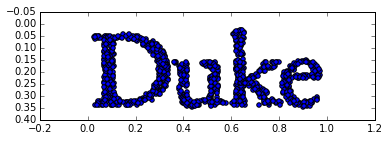

In [9]:
ax = plt.scatter(pts[:, 1], pts[:, 0])
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

## Make a bunch of purely random high-dimensional data

In [10]:
P = 2000

In [11]:
data = np.random.randn(N, P)

data -= np.min(data)

data /= np.max(np.abs(data))

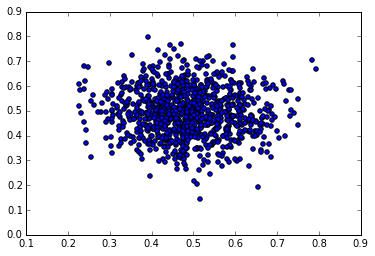

In [12]:
plt.scatter(data[:, 0], data[:, 1]);

## Find a projection where this random cloud looks like structure

In [13]:
soln = np.linalg.lstsq(data, pts)
X = soln[0]

And we can verify that the projection of the data by $X$ gives "structure"

In [14]:
proj = data.dot(X)

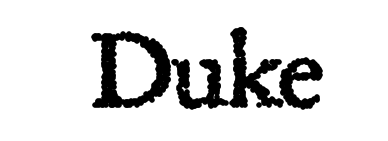

In [15]:
ax = plt.scatter(proj[:, 1], proj[:, 0], edgecolor=None, facecolor='k')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.axis('off');

## Let's make a movie!

Set up figure, axes, etc.

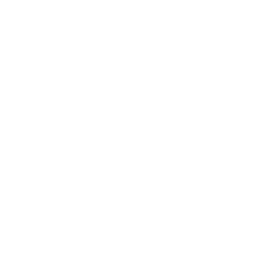

In [16]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
ax.set_aspect('equal')
ax.invert_yaxis()
plt.axis('off')

fps = 60
T = 5
Nf = T * fps

# this will be our pointcloud
coll = plt.scatter([], [], edgecolor=None, facecolor='k', animated=True)

In [17]:
# init function
def init():
    #coll.get_paths()[0].vertices = np.empty((0, 2))
    coll.set_offsets(np.empty((1, 2)))
    return coll,

In [18]:
# animation function.  This is called sequentially
init_proj = np.zeros(X.shape)
init_proj[0:2, 0:2] = np.eye(2)

def animate(j):
    t = j / Nf
    
    # interpolate between start and stop
    Xt = t * X + (1 - t) * init_proj
    
    proj = data.dot(Xt)
    
    # remove mean
    ctr = (0.5, 0.5)
    proj -= np.mean(proj, 0)
    proj += ctr
    
    #coll.get_paths()[0].vertices = proj[:, [1, 0]]
    coll.set_offsets(proj[:, [1, 0]])
    return coll,

In [19]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nf, blit=True)

anim.save('projection.mp4', fps=fps, extra_args=['-vcodec', 'h264', '-pix_fmt', 'yuv420p'])